### Marketing channel analysis

마케팅 채널 A로 가입한 회원과 마케팅 채널 B로 가입한 회원의 가입 후 **회원당 평균 매출액의 차이**가 유의미한가?  

채널 A, B로 가입한 회원들의 인당 매출액을 각 모집단으로 정의하면, 두 모집단의 평균 차이를 검증하는 문제가 된다.  
즉, 구하고자 하는 모수는 두 모집단의 평균값의 차이이며, 이 차이가 통계적으로 유의미한지 검증하기 위해 **독립표본 t 검정**을 사용한다.  

독립표본 t 검정을 하기 위해서는 결과값이 연속형 변수여야 하고, 데이터가 정규성을 만족하며 독립된 표본이어야 한다.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df_users = pd.read_csv('df_users.csv')
df_user_activities = pd.read_csv('df_user_activities.csv')
user_info = pd.merge(df_users, df_user_activities, how='outer') #outer join
user_info.to_csv('user_info.csv', index=False)

In [3]:
user_info.shape

(445220, 8)

In [4]:
user_info.columns

Index(['user_uuid', 'marketing_channel', 'sex', 'age_group', 'date_joined',
       'os', 'visits', 'revenue'],
      dtype='object')

In [5]:
chan_rev = user_info.loc[:, ['marketing_channel', 'revenue']]
chan_rev.info() #revenue(target var.) is float -> continuous var.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445220 entries, 0 to 445219
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketing_channel  445220 non-null  object 
 1   revenue            405085 non-null  float64
dtypes: float64(1), object(1)
memory usage: 10.2+ MB


revenue column에 있는 결측치들의 의미는, **가입 후 데이터 추출 날짜까지 매출을 전혀 발생시키지 않은 사용자가 존재한다**는 것이다.  
전체 데이터 중 약 10%에 해당하는 결측치의 경우, row를 제거하거나 다른 값으로 대체해야 한다.
다른 값으로 대체한다면, 매출이 전혀 발생하지 않은 경우를 의미하므로 0을 사용하는 것이 합리적이다.
그러나 결측치를 모두 0으로 대체할 경우 0의 비중이 너무 커서 revenue 를 정규화하기 어려워진다.  
따라서 이 문제에 독립표본 t 검정을 사용하기 위해서는 **정규성을 만족해야 하므로, 결측치를 0으로 대체하는 대신 제거하는 방식**을 선택했다.

In [6]:
chan_rev.isnull().sum()

marketing_channel        0
revenue              40135
dtype: int64

In [7]:
chan_rev.dropna(0, inplace=True)
print(chan_rev.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405085 entries, 0 to 445219
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketing_channel  405085 non-null  object 
 1   revenue            405085 non-null  float64
dtypes: float64(1), object(1)
memory usage: 9.3+ MB
None


In [8]:
rev_A = chan_rev.loc[chan_rev['marketing_channel'] == 'channel_A', 'revenue']
rev_B = chan_rev.loc[chan_rev['marketing_channel'] == 'channel_B', 'revenue']

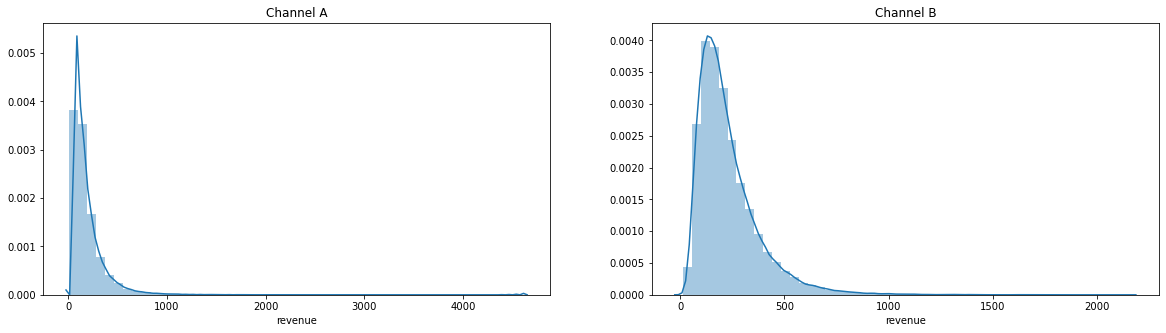

A: 	Skewness: 3.633746, Kurtosis: 27.695808
B: 	Skewness: 2.144816, Kurtosis: 8.355914


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(rev_A, ax=ax1)
ax1.set_title('Channel A')
sns.distplot(rev_B, ax=ax2)
ax2.set_title('Channel B')
plt.show()

print("A: \tSkewness: %f, Kurtosis: %f" % (rev_A.skew(), rev_A.kurt())) 
print("B: \tSkewness: %f, Kurtosis: %f" % (rev_B.skew(), rev_B.kurt()))

정규성검정을 위해 Anderson-Darling test와 QQ plot을 수행하였고, 데이터가 정규분포를 따르지 않음을 확인할 수 있다.

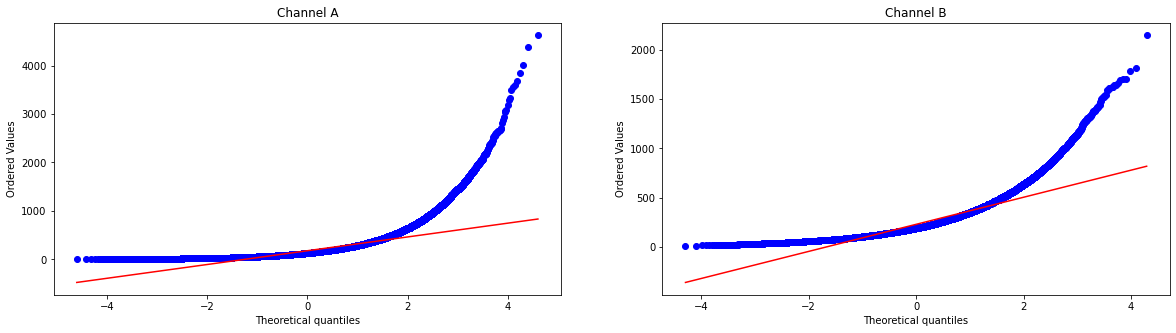

AndersonResult(statistic=20669.76695076708, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=2689.613151241603, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
stats.probplot(rev_A, dist=stats.norm, plot=ax1)
ax1.set_title('Channel A')
stats.probplot(rev_B, dist=stats.norm, plot=ax2)
ax2.set_title('Channel B')
plt.show()

print(stats.anderson(rev_A, dist='norm'))
print(stats.anderson(rev_B, dist='norm'))

데이터를 정규분포에 가깝게 만들기 위해 log 변환을 취한 결과이다.  
plot을 보면 정규분포와 유사한 형태를 보이며 왜도와 첨도도 감소하였다.

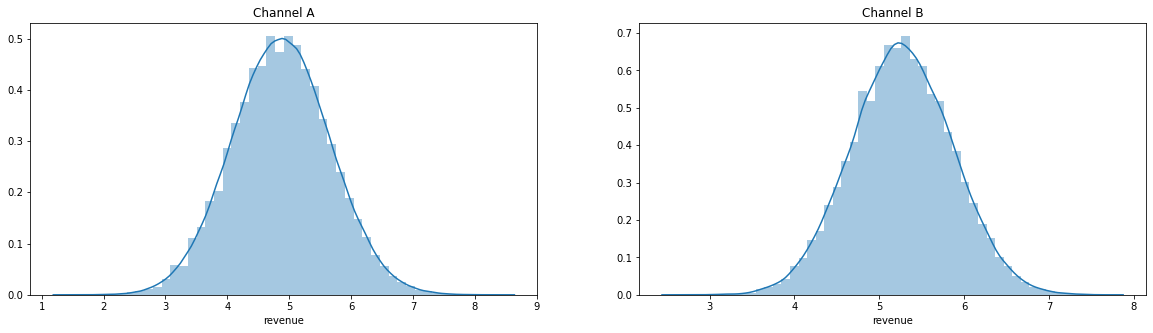

A: 	Skewness: 0.025773, Kurtosis: -0.017747
B: 	Skewness: 0.009129, Kurtosis: -0.031733


In [11]:
log_rev_A = np.log(rev_A + 1)
log_rev_B = np.log(rev_B + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(log_rev_A, ax=ax1)
ax1.set_title('Channel A')
sns.distplot(log_rev_B, ax=ax2)
ax2.set_title('Channel B')
plt.show()

print("A: \tSkewness: %f, Kurtosis: %f" % (log_rev_A.skew(), log_rev_A.kurt())) 
print("B: \tSkewness: %f, Kurtosis: %f" % (log_rev_B.skew(), log_rev_B.kurt()))

Anderson-Darling test에서 log_rev_B가 정규분포를 따름을 확인할 수 있다.  
또한 QQ plot에서 각 점의 분포가 직선에 매우 가까우므로 두 데이터 모두 정규분포를 따른다고 가정할 수 있다.

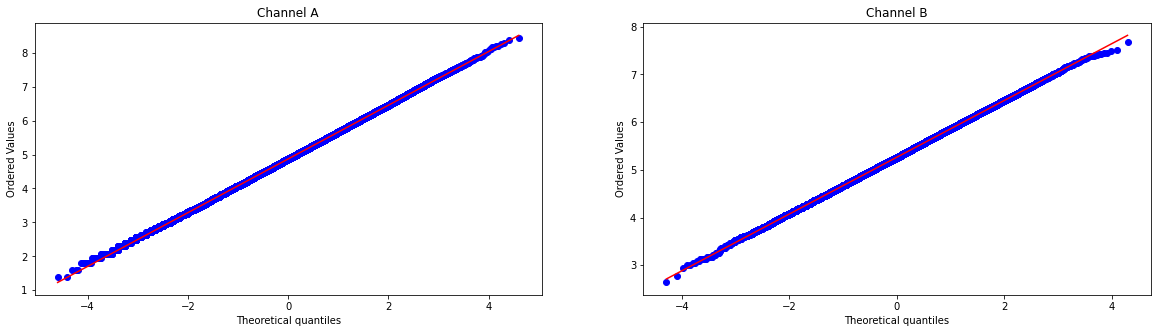

AndersonResult(statistic=4.337678556970786, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=0.8562838593352353, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
stats.probplot(log_rev_A, dist=stats.norm, plot=ax1)
ax1.set_title('Channel A')
stats.probplot(log_rev_B, dist=stats.norm, plot=ax2)
ax2.set_title('Channel B')
plt.show()

print(stats.anderson(log_rev_A, dist='norm')) #result: not normal
print(stats.anderson(log_rev_B, dist='norm')) #result: 2.5 sig level 에서 normal dist

모든 회원은 channel A와 B 중 하나를 통해 가입한다고 가정하므로, A로 가입한 그룹과 B로 가입한 그룹은 서로 영향을 받지 않아 독립적인 표본이다.  
독립표본 t 검정은 두 집단이 등분산인 경우와 이분산인 경우 다르게 적용되므로, 등분산성을 먼저 확인해야 한다.

* Levene, Bartlett 등분산 검정  
귀무가설: 두 집단의 분산이 동일하다.  
귀무가설을 기각하여, 두 집단의 분산은 다름을 알 수 있다.

In [13]:
print(stats.bartlett(log_rev_A, log_rev_B))
print(stats.levene(log_rev_A, log_rev_B))

BartlettResult(statistic=8951.95951470258, pvalue=0.0)
LeveneResult(statistic=7350.507232912135, pvalue=0.0)


* 이분산 t 검정  
귀무가설: 두 집단의 평균 매출액이 같다.  
귀무가설을 기각하여, **채널별 평균 매출액이 통계적으로 유의미한 차이를 가진다**는 결론을 내릴 수 있다.

In [14]:
print(stats.ttest_ind(log_rev_A, log_rev_B, equal_var=False))

Ttest_indResult(statistic=-154.29568239841566, pvalue=0.0)


A: 	Mean: 177.753957, Standard deviation: 168.537754
B: 	Mean: 229.930795, Standard deviation: 150.377904


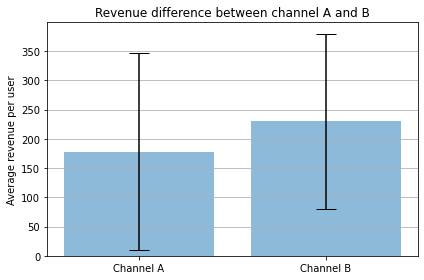

In [15]:
rev_A_mean = np.mean(rev_A)
rev_B_mean = np.mean(rev_B)
rev_A_std = np.std(rev_A)
rev_B_std = np.std(rev_B)
print("A: \tMean: %f, Standard deviation: %f" % (rev_A_mean, rev_A_std))
print("B: \tMean: %f, Standard deviation: %f" % (rev_B_mean, rev_B_std)) 

labels = ['Channel A', 'Channel B']
x_pos = np.arange(len(labels))
avg = [rev_A_mean, rev_B_mean]
error = [rev_A_std, rev_B_std]

fig, ax = plt.subplots()
ax.bar(x_pos, avg, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average revenue per user')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Revenue difference between channel A and B')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

따라서 Channel B의 고객들의 평균 매출액이 Channel A에 비해 크게 나타났다.